In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from dotenv import load_dotenv, find_dotenv
import os
from datetime import date, timedelta

pd.set_option("display.max_columns", None)


In [2]:
dotenv_path = find_dotenv()
load_dotenv(dotenv_path)
FACEIT_PLAYERID = os.environ.get("FACEIT_PLAYERID")


In [3]:
columns_to_keep_games_stats = [
    "PlayerId",
    "CreatedAt",
    "Map",
    "Kills",
    "Deaths",
    "Assists",
    "Headshots",
    "FirstHalfScore",
    "SecondHalfScore",
    "QuadroKills",
    "TripleKills",
    "PentaKills",
    "Headshots",
    "Headshots%",
    "K/rRatio",
    "K/dRatio",
    "Mvps",
    "OvertimeScore",
    "Rounds",
    "Score",
    "Result",
]


In [4]:
def rename_cols(text: str):
    text = text.split(".")[1]
    text = text.split(" ")
    text = "".join(list(map(str.capitalize, text)))
    return text


def read_json():
    with open(
        f"../data/raw/Game Stats/{FACEIT_PLAYERID}_games_stats.json", "r"
    ) as file:
        obj = json.load(file)
    df = pd.json_normalize(obj)
    df = df.rename(columns=rename_cols)
    return df


In [5]:
df = read_json()  # [columns_to_keep_games_stats]


In [6]:
type_casting = {
    "PlayerId": str,
    "CreatedAt": "datetime64[ns]",
    "UpdatedAt": "datetime64[ns]",
    "Kills": int,
    "Deaths": int,
    "Assists": int,
    "Headshots": int,
    "FirstHalfScore": int,
    "SecondHalfScore": int,
    "QuadroKills": int,
    "TripleKills": int,
    "PentaKills": int,
    "Headshots%": int,
    "Mvps": int,
    "OvertimeScore": int,
    "Rounds": int,
}
df = df.astype(type_casting, errors="ignore")
df.dropna(how="any", inplace=True)
df["Result"] = df["Result"].astype(int).replace({1: "Win", 0: "Lose"})
df["SteamData"] = False
df["Score"] = df["Score"].str.replace(" / ", ":")



In [7]:
df2 = pd.read_pickle("./DataCompressedSteam.pkl", "zip")


In [8]:
common_columns = [
    "PlayerId",
    "Kills",
    "Assists",
    "Deaths",
    "Mvps",
    "Headshots%",
    "Score",
    "Map",
    "Result",
    "CreatedAt",
    "SteamData",
]


In [9]:
DF = pd.concat(
    [df[common_columns], df2[common_columns]], join="inner", ignore_index=True
)
DF["Result"].replace({"True": "Won", "False": "Loss"}, inplace=True)

DF["Rounds"] = DF["Score"].str.split(":").apply(lambda x: int(x[0]) + int(x[1]))



In [10]:
DF["DateOrdinal"] = DF["CreatedAt"].apply(lambda date: date.toordinal())


In [11]:
rename_maps = {
    "Mirage": "de_mirage",
    "Cache": "de_cache",
    "Dust II": "de_dust2",
    "Overpass": "de_overpass",
    "Inferno": "de_inferno",
    "Cobblestone": "de_cbble",
    "Train": "de_train",
    "Office": "de_office",
    "Nuke": "de_nuke",
}

DF["Map"].replace(rename_maps, inplace=True)


In [12]:
def set_date_labels(ax):
    new_labels = [
        date.fromordinal(int(item)).strftime("%m/%Y") for item in ax.get_xticks()
    ]
    ax.set_xlabel(new_labels)
    return ax


In [13]:
cols = [
    "Kills",
    "Deaths",
    "Assists",
    "Headshots",
    "FirstHalfScore",
    "SecondHalfScore",
    "QuadroKills",
    "TripleKills",
    "PentaKills",
    "Mvps",
    "OvertimeScore",
    "Rounds",
]

overall_cols = ["Kills", "Deaths", "Assists", "Headshots", "Mvps"]


In [14]:
DF["Year"] = DF["CreatedAt"].dt.year
DF["Month"] = DF["CreatedAt"].dt.month
DF["Day"] = DF["CreatedAt"].dt.day


In [15]:
DF.query("Map != 'de_office'", inplace=True)

C:\Users\local_ec22805\Temp\ipykernel_12012\3693022287.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(new_labels, rotation=30)


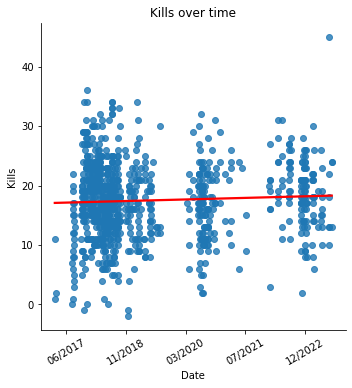

In [16]:
g = sns.lmplot(
    data=DF,
    x="DateOrdinal",
    y="Kills",
    ci=None,
    line_kws={"color": "red"},
    facet_kws=dict(sharex=False, sharey=True),
)
# plt.title("Kills over time")
for ax in g.axes.flat:
    new_labels = [
        date.fromordinal(int(item)).strftime("%m/%Y") for item in ax.get_xticks()
    ]
    ax.set_xticklabels(new_labels, rotation=30)
    ax.set_xlabel("Date")
    ax.set_title("Kills over time")

plt.show()


C:\Users\local_ec22805\Temp\ipykernel_12012\2694988399.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(new_labels, rotation=30)


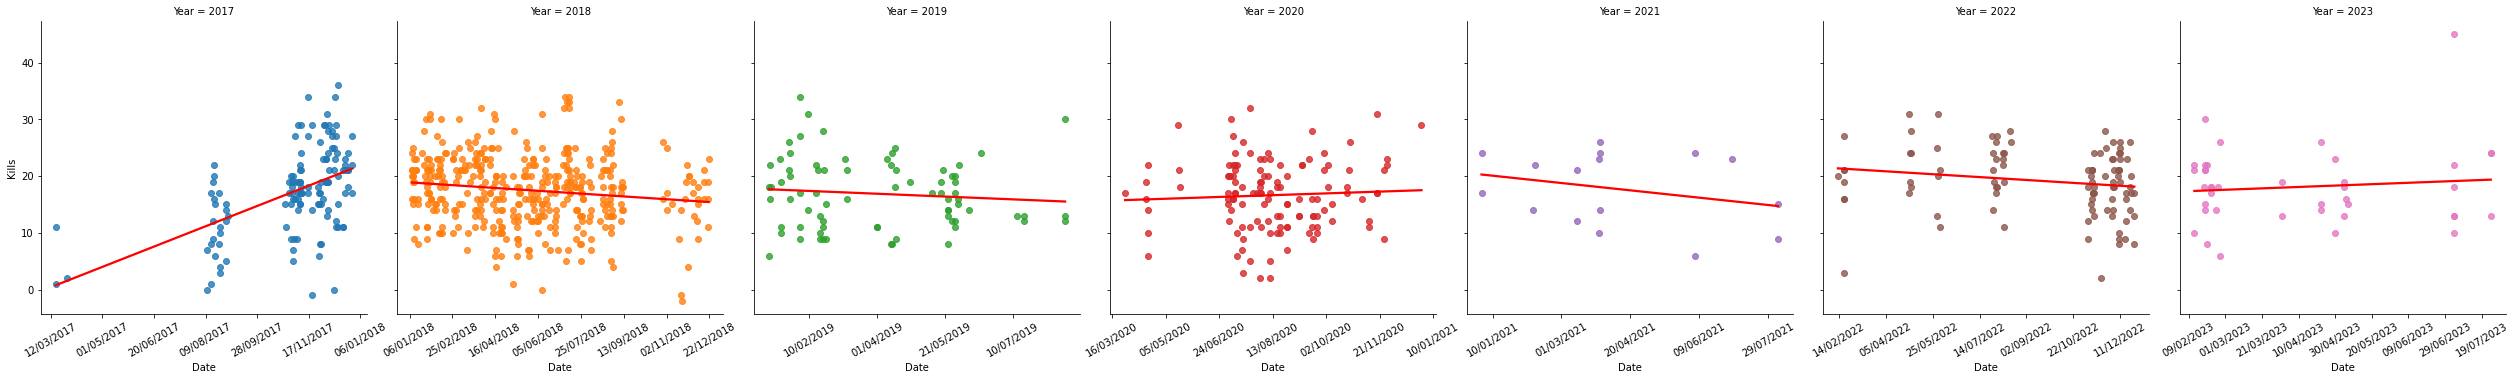

In [17]:
g = sns.lmplot(
    data=DF,
    x="DateOrdinal",
    y="Kills",
    ci=None,
    col="Year",
    hue="Year",
    line_kws={"color": "red"},
    facet_kws=dict(sharex=False, sharey=True),
)
# plt.title("Kills over time")
for ax in g.axes.flat:
    new_labels = [
        date.fromordinal(int(item)).strftime("%d/%m/%Y") for item in ax.get_xticks()
    ]
    ax.set_xticklabels(new_labels, rotation=30)
    ax.set_xlabel("Date")
    # ax.set_title("Kills over time in 2018")
plt.show()


In [18]:
DF.select_dtypes(include=np.number).columns.tolist()
Maps = (
    DF.groupby(by="Map")
    .aggregate(
        {
            "Kills": sum,
            "Deaths": sum,
            "Mvps": sum,
            "Map": "count",
            "Headshots%" : "mean",
            "Result": lambda x: pd.value_counts(x)[0],
        }
    )
    .rename({"Map": "TimesPlayed"}, axis=1)
)


In [19]:
Maps["WinRate%"] = (Maps["Result"] / Maps["TimesPlayed"] * 100).astype(int)


In [20]:
Maps.sort_values(by="TimesPlayed", inplace=True, ascending=False)
Maps["K/D"] = round(Maps["Kills"] / Maps["Deaths"], 2)


In [21]:
def func(pct, allvalues):
    absolute = max(int(pct / 100 * np.sum(allvalues)), 1)
    return "{:.1f}%\n({:d} games)".format(pct, absolute)


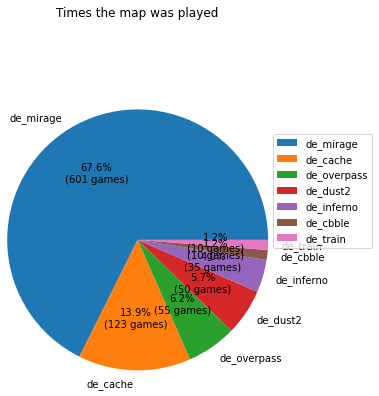

In [22]:
fig, ax = plt.subplots()
data = Maps.query("TimesPlayed > 10")["TimesPlayed"]
p, tx, autotexts = ax.pie(
    data, labels=data.index, autopct=lambda pct: func(pct, data), radius=1.5
)
ax.xaxis.set_label_position("top")
ax.set_title("Times the map was played", y=1.5)

plt.legend(bbox_to_anchor=(1.6, 1.01))
plt.show()


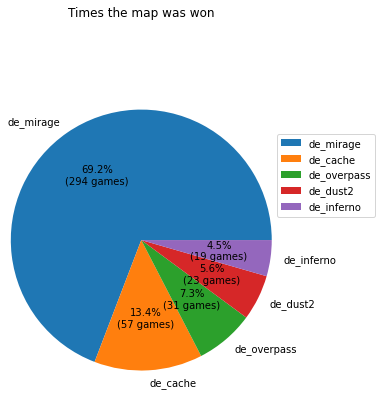

In [23]:
fig, ax = plt.subplots()
data = Maps.query("Result > 10")["Result"]

ax.pie(
    data,
    labels=data.index,
    autopct=lambda pct: func(pct, data),
    radius=1.5,
)
ax.xaxis.set_label_position("top")
ax.set_title("Times the map was won", y=1.5)
plt.legend(bbox_to_anchor=(1.6, 1.01))
plt.show()


In [24]:
def heatmap(data, title=""):
    corr = data.corr()
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(corr, cmap="coolwarm", vmin=-1, vmax=1)
    fig.colorbar(cax)
    ticks = np.arange(0, len(corr.columns), 1)
    ax.set_xticks(ticks)
    plt.xticks(rotation=45)
    ax.set_yticks(ticks)
    ax.set_xticklabels(corr.columns)
    ax.set_yticklabels(corr.columns)

    matrix = pd.DataFrame(data.corr(method="pearson")).round(2)
    for i in range(len(matrix)):
        for j in range(len(matrix.iloc[0])):
            text = ax.text(j, i, matrix.iloc[i, j], ha="center", va="center", color="w")
    ax.set_title(title, pad=20)


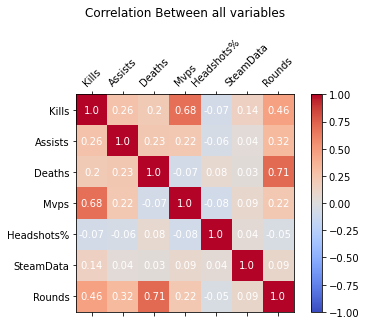

In [25]:
heatmap(
    DF.drop(columns=["Year", "Month", "Day", "DateOrdinal"]),
    title="Correlation Between all variables",
)
# there is a correlation between installs and rating count -> more people installs leads to more people commenting
# next to no correlaiton between everything


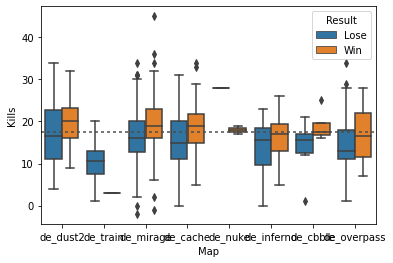

In [26]:
mean = DF["Kills"].mean()

ax = sns.boxplot(
    data=DF.query("Result in ['Lose', 'Win']"), y="Kills", x="Map", hue="Result"
)
ax.axhline(mean, color=".3", dashes=(2, 2))
plt.show()


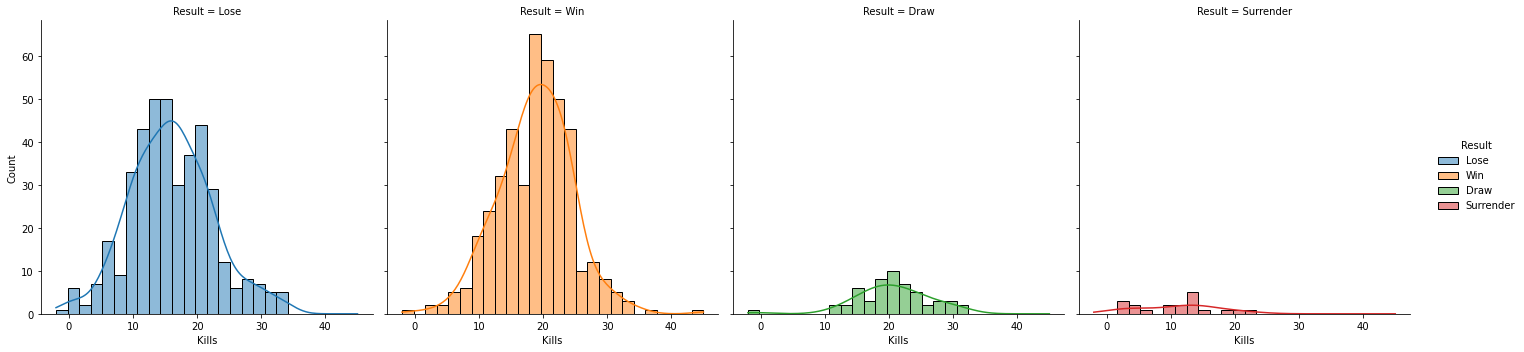

In [27]:
sns.displot(
    data=DF,
    x="Kills",
    col="Result",
    hue="Result",
    kde=True,
    facet_kws=dict(sharex=False, sharey=True),
)


In [28]:
def count_wins(x):
    wins = pd.value_counts(x).get("Win")
    if wins:
        return wins
    else:
        return 0


In [29]:
YearlyData = (
    DF.groupby(["Year", "Month"], as_index=False)
    .aggregate(
        {
            "Kills": "sum",
            "Assists": "sum",
            "Deaths": "sum",
            "Headshots%": "mean",
            "Map": "count",
            "Result": lambda x: count_wins(x),
        }
    )
    .rename({"Map": "TimesPlayed", "Result": "TimesWon"}, axis=1)
)


In [30]:
YearlyData.head()


,Year,Month,Kills,Assists,Deaths,Headshots%,TimesPlayed,TimesWon
0,2017,3,14,6,54,75.666667,3,0
1,2017,8,264,108,408,33.208333,24,10
2,2017,10,106,33,124,48.285714,7,3
3,2017,11,833,180,714,43.812500,48,22
4,2017,12,1023,232,743,40.333333,48,27


In [31]:
YearlyData["WinRate"] = (
    YearlyData["TimesWon"] / YearlyData["TimesPlayed"] * 100
).astype(int)


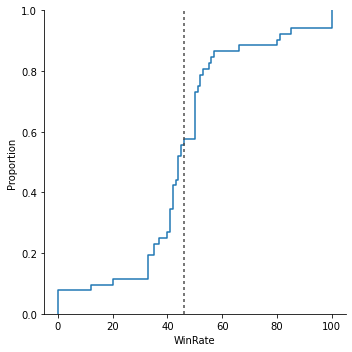

In [32]:
winrate = YearlyData["WinRate"].mean()
g = sns.displot(data=YearlyData, x="WinRate", kind="ecdf")
for ax in g.axes.flat:
    ax.axvline(x=winrate, color=".3", dashes=(2, 2))
plt.show()


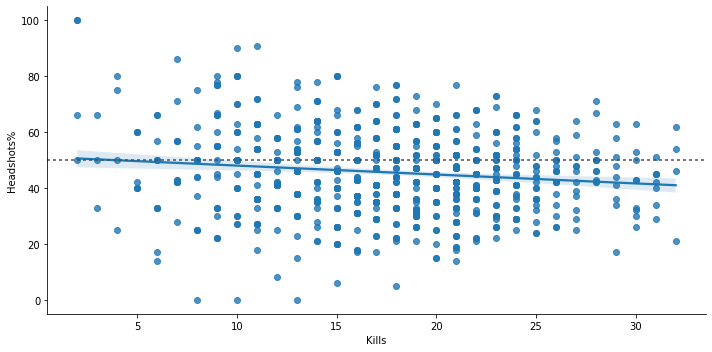

In [33]:
q_low = DF["Kills"].quantile(0.01)
q_hi = DF["Kills"].quantile(0.99)

DF_filtered = DF[(DF["Kills"] < q_hi) & (DF["Kills"] > q_low)]
g = sns.lmplot(data=DF_filtered, y="Headshots%", x="Kills", aspect=2)
for ax in g.axes.flat:
    ax.axhline(50, color=".3", dashes=(2, 2))
plt.show()


C:\Users\local_ec22805\Temp\ipykernel_12012\1656462616.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(new_labels, rotation=30)


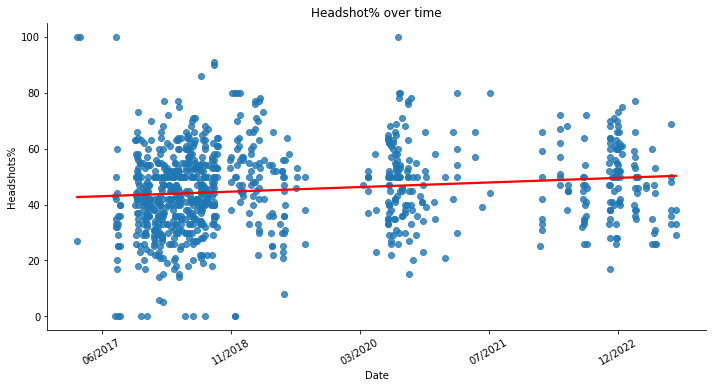

In [34]:
g = sns.lmplot(
    data=DF,
    x="DateOrdinal",
    y="Headshots%",
    ci=None,
    line_kws={"color": "red"},
    facet_kws=dict(sharex=False, sharey=True),
    aspect=2,
)
# plt.title("Kills over time")
for ax in g.axes.flat:
    new_labels = [
        date.fromordinal(int(item)).strftime("%m/%Y") for item in ax.get_xticks()
    ]
    ax.set_xticklabels(new_labels, rotation=30)
    ax.set_xlabel("Date")
    ax.set_title("Headshot% over time")
plt.show()


In [35]:
DF[DF["Headshots%"] > 95]


,PlayerId,Kills,Assists,Deaths,Mvps,Headshots%,Score,Map,Result,CreatedAt,SteamData,Rounds,DateOrdinal,Year,Month,Day
95,2fb9fe10-5c7e-4f2f-860b-a9ee2f88801a,1,0,6,1,100,1:9,de_overpass,Lose,2017-08-14 07:24:37.963,False,10,736555,2017,8,14
99,2fb9fe10-5c7e-4f2f-860b-a9ee2f88801a,2,0,18,0,100,2:16,de_mirage,Lose,2017-03-28 05:56:43.670,False,18,736416,2017,3,28
101,2fb9fe10-5c7e-4f2f-860b-a9ee2f88801a,1,0,10,0,100,11:1,de_cbble,Lose,2017-03-17 13:00:31.295,False,12,736405,2017,3,17
681,2fb9fe10-5c7e-4f2f-860b-a9ee2f88801a,2,2,12,0,100,12:1,de_inferno,Surrender,2020-08-10 17:11:37.000,True,13,737647,2020,8,10


C:\Users\local_ec22805\Temp\ipykernel_12012\367983270.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(new_labels, rotation=30)


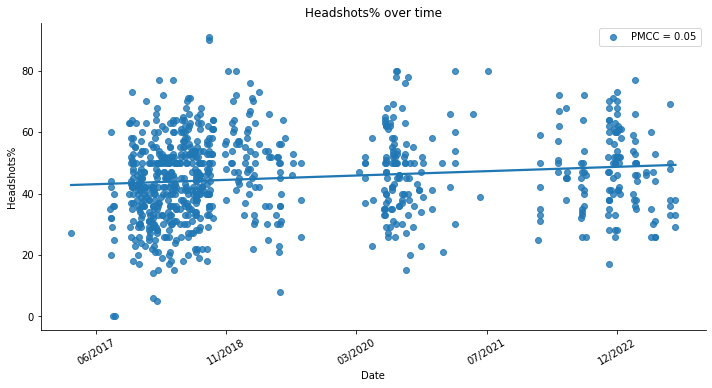

In [36]:
data = DF[DF["Kills"] >= 10]

g = sns.lmplot(
    data=data,
    x="DateOrdinal",
    y="Headshots%",
    ci=None,
    facet_kws=dict(sharex=False, sharey=True),
    aspect=2,
)
# plt.title("Kills over time")
for ax in g.axes.flat:
    new_labels = [
        date.fromordinal(int(item)).strftime("%m/%Y") for item in ax.get_xticks()
    ]

    ax.collections[0].set_label(f'PMCC = {np.corrcoef(DF["Kills"], DF["DateOrdinal"])[0,1]:.2f}')
    ax.set_xticklabels(new_labels, rotation=30)
    ax.set_xlabel("Date")
    ax.set_title("Headshots% over time")
    ax.legend()
# plt.show()

Text(20.513422818791945, 288, 'mean: 18')

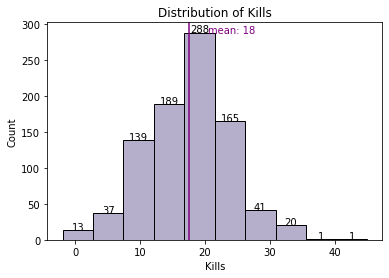

In [37]:
ax = sns.histplot(DF["Kills"], color="#9d94ba", bins=10, kde=False)
ax.set(title="Distribution of Kills")
# label each bar in histogram
for p in ax.patches:
    height = p.get_height()  # get the height of each bar
    # adding text to each bar
    ax.text(
        x=p.get_x()
        + (
            p.get_width() / 2
        ),  # x-coordinate position of data label, padded to be in the middle of the bar
        y=height + 0.2,  # y-coordinate position of data label, padded 0.2 above bar
        s="{:.0f}".format(height),  # data label, formatted to ignore decimals
        ha="center",
    )

plt.axvline(DF["Kills"].mean(), color="purple", label="mean")
# adding data label to mean line
plt.text(
    x=DF["Kills"].mean()
    + 3,  # x-coordinate position of data label, adjusted to be 3 right of the data point
    y=max(
        [h.get_height() for h in ax.patches]
    ),  # y-coordinate position of data label, to take max height
    s="mean: {:.0f}".format(DF["Kills"].mean()),  # data label
    color="purple",
)  # colour


#https://medium.com/swlh/quick-guide-to-labelling-data-for-common-seaborn-plots-736e10bf14a9

C:\tools\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 18.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='Map', ylabel='Headshots%'>

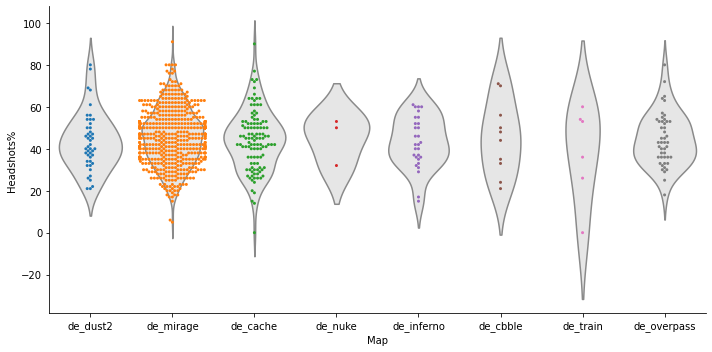

In [38]:
data = DF[(DF["Kills"] >= 10) & (DF["Result"] != "Surrender")]
# sns.catplot(
#     data = data,
#     x = "Map",
#     y = "Headshots%",
#     kind = "box",
#     aspect=1.5,
# )

sns.catplot(
    data=data, x="Map", y="Headshots%", kind="violin", color=".9", inner=None, aspect=2
)
sns.swarmplot(data=data, x="Map", y="Headshots%", size=3)


In [52]:
data

,PlayerId,Kills,Assists,Deaths,Mvps,Headshots%,Score,Map,Result,CreatedAt,SteamData,Rounds,DateOrdinal,Year,Month,Day
0,2fb9fe10-5c7e-4f2f-860b-a9ee2f88801a,17,3,16,2,47,16:9,de_dust2,Lose,2020-03-28 23:24:01.382,False,25,737512,2020,3,28
2,2fb9fe10-5c7e-4f2f-860b-a9ee2f88801a,15,0,18,1,53,16:7,de_mirage,Lose,2019-02-22 00:47:37.372,False,23,737112,2019,2,22
3,2fb9fe10-5c7e-4f2f-860b-a9ee2f88801a,18,3,19,5,61,13:16,de_cache,Win,2018-09-12 08:15:31.590,False,29,736949,2018,9,12
4,2fb9fe10-5c7e-4f2f-860b-a9ee2f88801a,14,2,10,1,64,16:5,de_mirage,Win,2018-09-12 07:14:34.446,False,21,736949,2018,9,12
5,2fb9fe10-5c7e-4f2f-860b-a9ee2f88801a,19,7,14,3,32,7:16,de_dust2,Win,2018-09-11 07:37:03.535,False,23,736948,2018,9,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
890,2fb9fe10-5c7e-4f2f-860b-a9ee2f88801a,45,7,15,8,48,13:16,de_mirage,Win,2023-07-04 14:45:58.000,True,29,738705,2023,7,4
891,2fb9fe10-5c7e-4f2f-860b-a9ee2f88801a,18,2,4,4,33,16:1,de_mirage,Win,2023-07-04 15:43:26.000,True,17,738705,2023,7,4
892,2fb9fe10-5c7e-4f2f-860b-a9ee2f88801a,24,8,18,3,33,16:12,de_mirage,Win,2023-07-24 12:47:49.000,True,28,738725,2023,7,24
893,2fb9fe10-5c7e-4f2f-860b-a9ee2f88801a,13,6,14,3,38,5:16,de_mirage,Win,2023-07-24 14:43:01.000,True,21,738725,2023,7,24


In [40]:
Maps;

,Kills,Deaths,Mvps,TimesPlayed,Headshots%,Result,WinRate%,K/D
Map,,,,,,,,
de_mirage,10753,10013,1469,602,45.875415,294,48,1.07
de_cache,2153,2144,280,124,44.274194,57,45,1.00
de_overpass,872,946,110,55,45.363636,31,56,0.92
de_dust2,953,868,133,51,43.490196,24,47,1.10
de_inferno,549,564,66,36,42.638889,19,52,0.97
de_cbble,190,194,26,11,50.181818,6,54,0.98
de_train,107,195,9,11,41.545455,10,90,0.55
de_nuke,80,80,11,4,47.500000,2,50,1.00


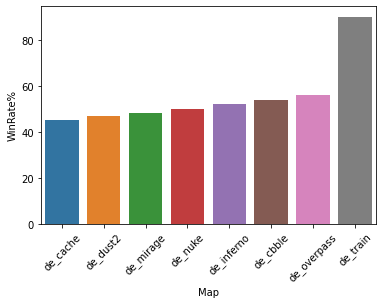

In [41]:
sns.barplot(data = Maps, x = Maps.index, y = Maps["WinRate%"], order = Maps.sort_values(by = "WinRate%").index)
plt.xticks(rotation = 45)
plt.show()

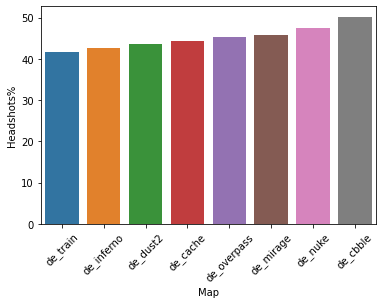

In [42]:
sns.barplot(data = Maps, x = Maps.index, y = Maps["Headshots%"], order = Maps.sort_values(by = "Headshots%").index)
plt.xticks(rotation = 45)
plt.show()

<AxesSubplot:xlabel='Map', ylabel='TimesPlayed'>

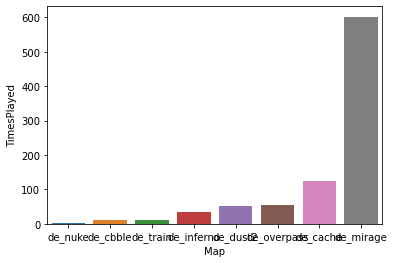

In [43]:
sns.barplot(data=Maps, y = "TimesPlayed", x = Maps.index, order=Maps.sort_values(by = "TimesPlayed").index)

<AxesSubplot:xlabel='Map', ylabel='WinRate%'>

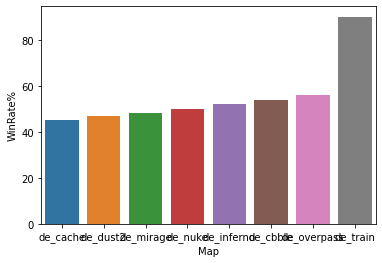

In [44]:
sns.barplot(data=Maps, y = "WinRate%", x = Maps.index, order=Maps.sort_values(by = "WinRate%").index)


In [45]:
DF["K/D"] = DF["Kills"]/DF["Deaths"]
DF["K/A"] = DF["Kills"]/DF["Assists"]

In [46]:
DF.reset_index(inplace=True)

In [47]:
DF.head()

,index,PlayerId,Kills,Assists,Deaths,Mvps,Headshots%,Score,Map,Result,CreatedAt,SteamData,Rounds,DateOrdinal,Year,Month,Day,K/D,K/A
0,0,2fb9fe10-5c7e-4f2f-860b-a9ee2f88801a,17,3,16,2,47,16:9,de_dust2,Lose,2020-03-28 23:24:01.382,False,25,737512,2020,3,28,1.062500,5.666667
1,1,2fb9fe10-5c7e-4f2f-860b-sa9ee2f88801a,9,0,21,0,78,16:8,de_train,Lose,2019-02-22 01:46:04.960,False,24,737112,2019,2,22,0.428571,inf
2,2,2fb9fe10-5c7e-4f2f-860b-a9ee2f88801a,15,0,18,1,53,16:7,de_mirage,Lose,2019-02-22 00:47:37.372,False,23,737112,2019,2,22,0.833333,inf
3,3,2fb9fe10-5c7e-4f2f-860b-a9ee2f88801a,18,3,19,5,61,13:16,de_cache,Win,2018-09-12 08:15:31.590,False,29,736949,2018,9,12,0.947368,6.000000
4,4,2fb9fe10-5c7e-4f2f-860b-a9ee2f88801a,14,2,10,1,64,16:5,de_mirage,Win,2018-09-12 07:14:34.446,False,21,736949,2018,9,12,1.400000,7.000000


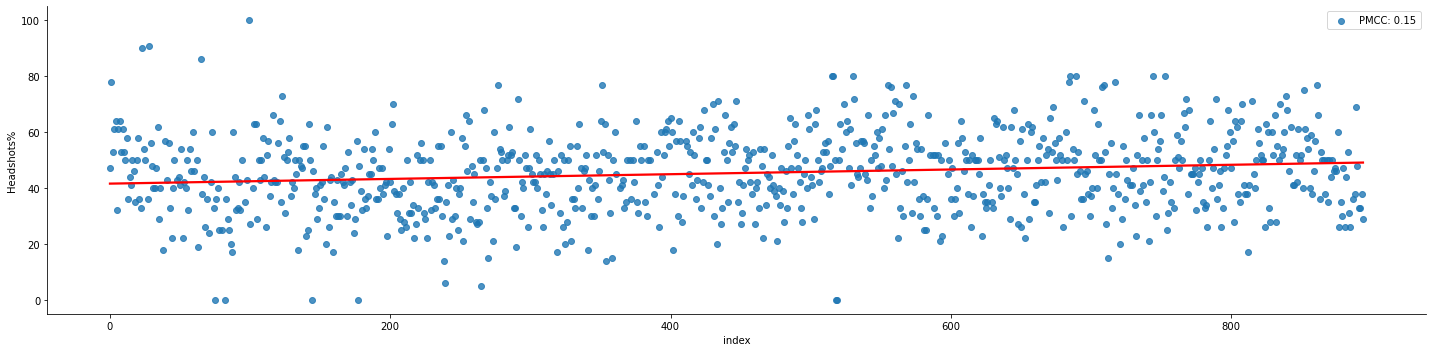

In [48]:
g = sns.lmplot(
    data=DF.query("Rounds > 16"),
    x="index",
    y="Headshots%",
    ci=None,
    line_kws={"color": "red"},
    facet_kws=dict(sharex=False, sharey=True),
    aspect=4,
    legend= True,
    # hue = "Result"
)
g.axes[0][0].axes.collections[0].set_label(f"PMCC: {round(np.corrcoef(DF['index'], DF['Headshots%'])[0,1], 2)}")
plt.tight_layout()
plt.legend()
plt.show()

In [49]:
DF = DF[DF["K/D"] >= 0]

C:\tools\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2536: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


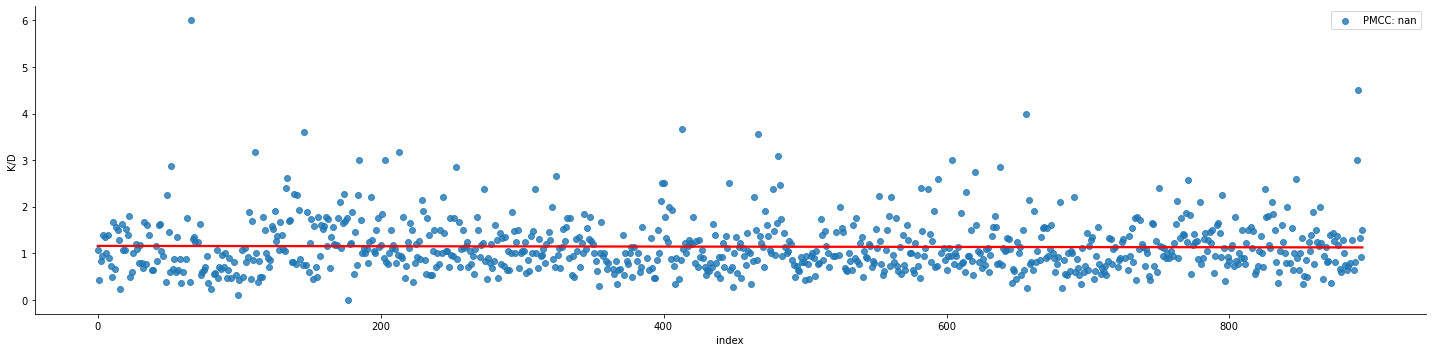

In [50]:
g = sns.lmplot(
    data=DF.query("Rounds > 16"),
    x="index",
    y="K/D",
    ci=None,
    line_kws={"color": "red"},
    facet_kws=dict(sharex=False, sharey=True),
    aspect=4,
    legend= True,
    # hue = "Result"
)
g.axes[0][0].axes.collections[0].set_label(f"PMCC: {round(np.corrcoef(DF['index'], DF['K/D'])[0,1], 2)}")
plt.tight_layout()
plt.legend()
plt.show()

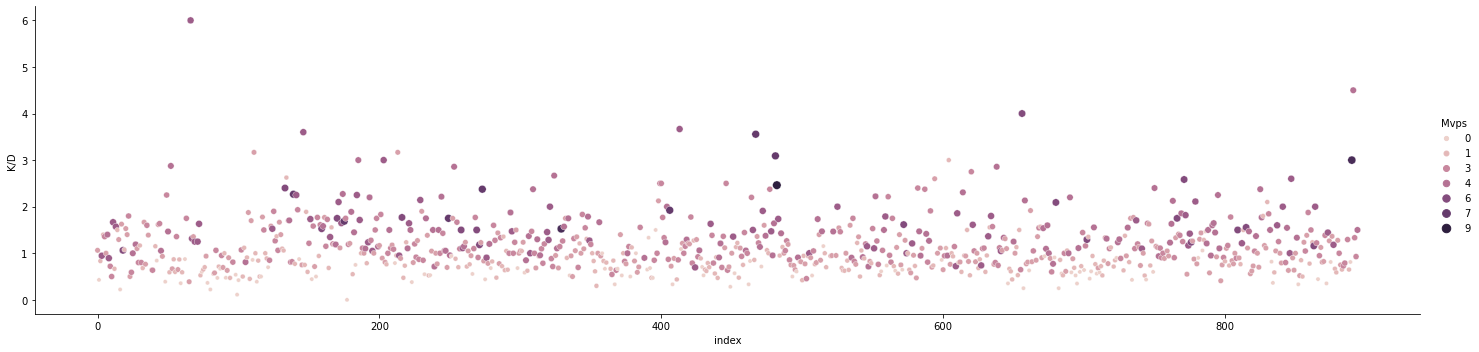

In [51]:
sns.relplot(data = DF[DF["Rounds"] > 16], x = "index", y = "K/D", hue = "Mvps", aspect = 4, size = "Mvps")